In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 11:09:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Find Normalization

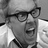

In [4]:
img_path = '../content/drive/MyDrive/Colab Notebooks/FER2013/train/angry/Training_3908.jpg'
img = Image.open(img_path)
display(img)

In [5]:
img_np = np.array(img)

Text(0.5, 1.0, 'distribution of pixels')

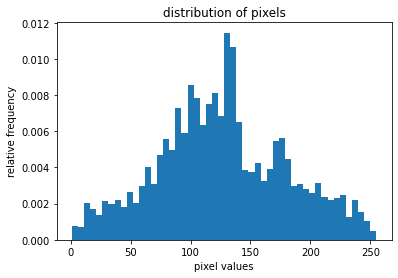

In [6]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [7]:
transform_img = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
img_tr = transform_img(img)
  
img_np = np.array(img_tr)

Text(0.5, 1.0, 'distribution of pixels')

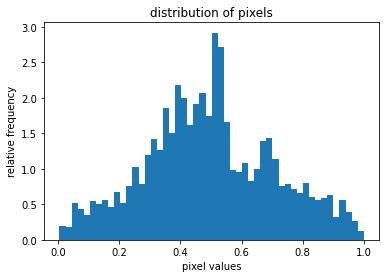

In [9]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [10]:
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

In [11]:
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4954])
Std of the image: tensor([0.2112])


Visualization

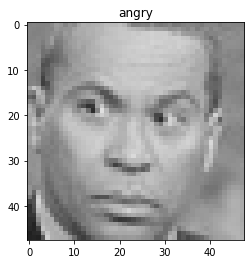

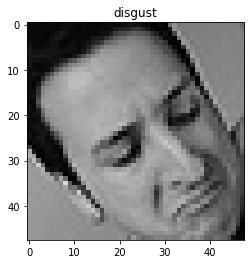

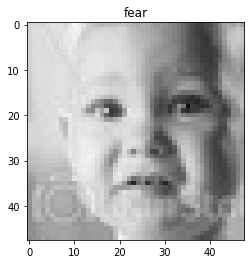

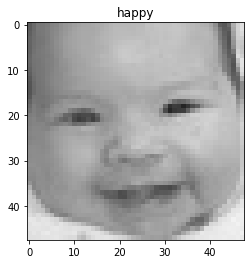

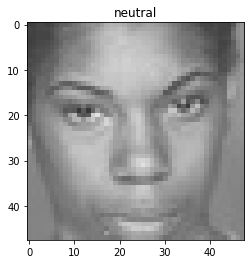

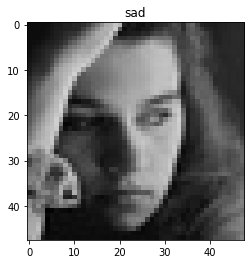

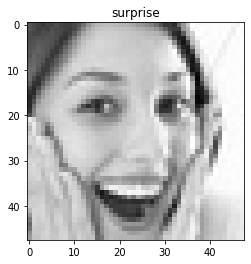

In [12]:
# Visualize one image from each category of the dataset

data_dir = ('../content/drive/MyDrive/Colab Notebooks/FER2013/train')
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for i in categories:
    path = os.path.join(data_dir, i)
    num = 0
    
    for img in os.listdir(path):
        
        if num == 1:
            break
        
        else:
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, (48, 48))
            plt.imshow(img_array)
            plt.title(i)
            plt.show()
            num +=1

In [13]:
image_files = os.listdir(path)
image = os.path.join(path, image_files[0])
image = cv2.imread(image)
image.shape

(48, 48, 3)

Define Transforms

In [14]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_transform = transforms.Compose([
      # transforms.CenterCrop(40),
      # transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      # transforms.Pad(15),
      # transforms.Resize(48),
      transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
      # transforms.CenterCrop(40),
      transforms.ToTensor(),
      # transforms.Pad(15),
      # transforms.Resize(48),
      transforms.Normalize(mean, std),
])

Datasets

In [15]:
root = '../content/drive/MyDrive/Colab Notebooks/FER2013/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [16]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 28709
     Root location: ../content/drive/MyDrive/Colab Notebooks/FER2013/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.4954]), std=tensor([0.2112]))
            ), Dataset ImageFolder
     Number of datapoints: 7178
     Root location: ../content/drive/MyDrive/Colab Notebooks/FER2013/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.4954]), std=tensor([0.2112]))
            ))

Load Data

In [17]:
torch.manual_seed(1234)
train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
test_loader = DataLoader(test_data, batch_size=30, shuffle=True)

class_names = train_data.classes

In [18]:
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Training images available: 28709
Testing images available:  7178


Display a batch of image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([30, 3, 48, 48])
Label: [4 6 3 0 3 5 4 5 2 3 2 0 5 2 0 3 0 3 4 3 5 4 2 0 2 2 3 4 5 3]
Class: neutral surprise happy angry happy sad neutral sad fear happy fear angry sad fear angry happy angry happy neutral happy sad neutral fear angry fear fear happy neutral sad happy


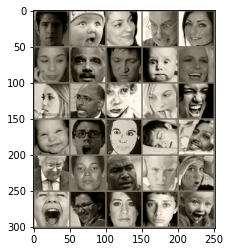

In [19]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

print(images.shape)
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Check the shape

In [20]:
conv1 = nn.Conv2d(3, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
conv3 = nn.Conv2d(16, 32, 3, 1)
conv4 = nn.Conv2d(32, 64, 3, 1)
dr = nn.Dropout(0.3)
bn1 = nn.BatchNorm2d(6)
bn2 = nn.BatchNorm2d(16)
bn3 = nn.BatchNorm2d(32)
bn4 = nn.BatchNorm2d(64)

In [21]:
# Grab the first record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [22]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1, 3, 48, 48)
print(x.shape)

torch.Size([1, 3, 48, 48])


In [23]:
x

tensor([[[[-1.4169, -1.7511, -2.0667,  ...,  0.1240,  0.4582, -0.7486],
          [-1.2870, -1.7140, -1.9368,  ...,  0.2168,  0.4582, -0.6929],
          [-1.2127, -1.7883, -1.8996,  ...,  0.2911,  0.4210, -0.6929],
          ...,
          [-0.4330, -0.4887, -0.4887,  ...,  0.4210, -0.4144, -0.7671],
          [-0.3587, -0.2844, -0.2473,  ...,  0.4582, -0.1174, -0.7486],
          [-0.4144, -0.4144, -0.2659,  ...,  0.3097,  0.1797, -0.8043]],

         [[-1.4169, -1.7511, -2.0667,  ...,  0.1240,  0.4582, -0.7486],
          [-1.2870, -1.7140, -1.9368,  ...,  0.2168,  0.4582, -0.6929],
          [-1.2127, -1.7883, -1.8996,  ...,  0.2911,  0.4210, -0.6929],
          ...,
          [-0.4330, -0.4887, -0.4887,  ...,  0.4210, -0.4144, -0.7671],
          [-0.3587, -0.2844, -0.2473,  ...,  0.4582, -0.1174, -0.7486],
          [-0.4144, -0.4144, -0.2659,  ...,  0.3097,  0.1797, -0.8043]],

         [[-1.4169, -1.7511, -2.0667,  ...,  0.1240,  0.4582, -0.7486],
          [-1.2870, -1.7140, -

In [24]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 46, 46])

In [25]:
x = bn1(x)
x.shape

torch.Size([1, 6, 46, 46])

In [26]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 44, 44])


In [27]:
x = bn2(x)
x.shape

torch.Size([1, 16, 44, 44])

In [28]:
x = dr(x)
x.shape

torch.Size([1, 16, 44, 44])

In [29]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 22, 22])


In [30]:
# Perform the third convolution/activation
x = F.relu(conv3(x))
print(x.shape)

torch.Size([1, 32, 20, 20])


In [31]:
x = bn3(x)
x.shape

torch.Size([1, 32, 20, 20])

In [32]:
# Perform the fourth convolution/activation
x = F.relu(conv4(x))
print(x.shape)

torch.Size([1, 64, 18, 18])


In [33]:
x = bn4(x)
x.shape

torch.Size([1, 64, 18, 18])

In [34]:
x = dr(x)
x.shape

torch.Size([1, 64, 18, 18])

In [35]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 64, 9, 9])


In [36]:
# Flatten the data
x = x.view(-1, 64*9*9)
print(x.shape)

torch.Size([1, 5184])


Define CNN model

In [37]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.dr = nn.Dropout(0.25)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.bnc1 = nn.BatchNorm1d(120)
        self.bnc2 = nn.BatchNorm1d(84)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.bn1(X)
        X = F.relu(self.conv2(X))
        X = self.bn2(X)
        X = self.dr(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = self.bn3(X)
        X = F.relu(self.conv4(X))
        X = self.bn4(X)
        X = self.dr(X)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 64*9*9)
        X = F.relu(self.fc1(X))
        X = self.bnc1(X)
        X = F.relu(self.fc2(X))
        X = self.bnc2(X)
        X = self.fc3(X)
        X = self.dr(X)
        return F.log_softmax(X, dim=1)

Define loss and activation function

In [38]:
torch.manual_seed(1234)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)

In [39]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dr): Dropout(p=0.25, inplace=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5184, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
  (bnc1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track

Trainable Parameters

In [40]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [41]:
count_parameters(CNNmodel)

     162
       6
     864
      16
    4608
      32
   18432
      64
       6
       6
      16
      16
      32
      32
      64
      64
  622080
     120
   10080
      84
     588
       7
     120
     120
      84
      84
________
  657787


Train the model

In [42]:
import time
start_time = time.time()

epochs = 50

max_trn_batch = 936
max_tst_batch = 240

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    CNNmodel.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%100 == 0 or b == 936:
            acc = trn_corr.item()*100/(30*b)
            print(f'epoch: {i+1:2}  batch: {b:4} loss: {loss.item():10.8f}  accuracy: {acc:7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    CNNmodel.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  1  batch:  100 loss: 1.80684340  accuracy:  23.633%
epoch:  1  batch:  200 loss: 1.79883206  accuracy:  27.717%
epoch:  1  batch:  300 loss: 1.84883392  accuracy:  29.156%
epoch:  1  batch:  400 loss: 1.55908716  accuracy:  30.775%
epoch:  1  batch:  500 loss: 1.45991337  accuracy:  31.807%
epoch:  1  batch:  600 loss: 1.65120196  accuracy:  32.789%
epoch:  1  batch:  700 loss: 1.35747194  accuracy:  33.400%
epoch:  1  batch:  800 loss: 1.48511922  accuracy:  34.071%
epoch:  1  batch:  900 loss: 1.28495359  accuracy:  34.881%
epoch:  1  batch:  936 loss: 1.39343262  accuracy:  35.032%
epoch:  2  batch:  100 loss: 1.72626698  accuracy:  42.033%
epoch:  2  batch:  200 loss: 1.39340699  accuracy:  41.383%
epoch:  2  batch:  300 loss: 1.44876826  accuracy:  41.311%
epoch:  2  batch:  400 loss: 1.39109612  accuracy:  41.700%
epoch:  2  batch:  500 loss: 1.32493162  accuracy:  41.960%
epoch:  2  batch:  600 loss: 1.26183665  accuracy:  42.072%
epoch:  2  batch:  700 loss: 1.55670321 

Save the trained model

In [43]:
torch.save(CNNmodel.state_dict(), 'CNNModel_EDBOFE.pt')

Plot loss and accuracy

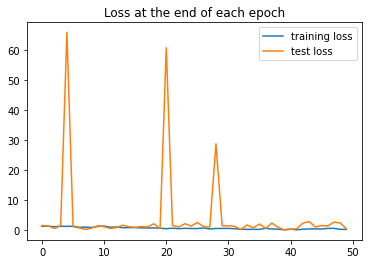

In [44]:
train_loss = [fl.item() for fl in train_losses]
test_loss = [fl.item() for fl in test_losses]
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

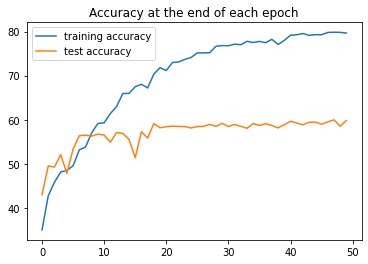

In [45]:
plt.plot([t*100/28079 for t in train_correct], label='training accuracy')
plt.plot([t*100/7178 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

Evaluate test data

In [46]:
# Extract the data all at once, not in batches
test_load_fer = DataLoader(test_data, batch_size=7178, shuffle=False)

CNNmodel.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_fer:
        y_val = CNNmodel(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy FER2013: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')


# test_data_ck = datasets.ImageFolder(os.path.join(root, 'CK+_test'), transform=test_transform)
# test_load_ck = DataLoader(test_data_ck, batch_size=246, shuffle=False)

# with torch.no_grad():
#     correct = 0
#     for X_test, y_test in test_load_ck:
#         y_val = CNNmodel(X_test)  
#         predicted = torch.max(y_val,1)[1]
#         correct += (predicted == y_test).sum()
# print(f'\nTest accuracy CK+: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')


# test_data_jaffe = datasets.ImageFolder(os.path.join(root, 'JAFFE_test'), transform=test_transform)
# test_load_jaffe = DataLoader(test_data_jaffe, batch_size=70, shuffle=False)

# with torch.no_grad():
#     correct = 0
#     for X_test, y_test in test_load_jaffe:
#         y_val = CNNmodel(X_test)  
#         predicted = torch.max(y_val,1)[1]
#         correct += (predicted == y_test).sum()
# print(f'\nTest accuracy JAFFE: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy FER2013: 4294/7178 =  59.822%
